**@author: James V. Talwar**
    
# Personalizing Age of Melanoma Onset Estimates in TCGA: Customizing Sojourn Time from Individual Clock-like Mutational Signatures

**About**: This notebook provides the code needed to generate **Supplementary Figure 12** from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). The analyses and figures provided here focused on: <br><br>
**1)** Selecting a melanoma mutational clock with the maximum correlation with age of diagnosis and minimum correlation with UV-associated mutational signatures (i.e., SBS7)<br>
**2)** Utilizing the (optimal) clock-like signature selected in **1)** above in conjunction with our two-stage model sex-specific estimates to personalize sojourn times <br>
**3)** Investigating whether MHC-I AI carriers associated with later personalized estimated age of onset across PRS quintiles <br>
**4)** Assessing reasonability of these personalized sojourn time estimates obtained in **2)** above <br>
**5)** Investigating whether MHC-I AI carriers associated with differing (either longer or shorter) estimated sojourn times

## 1. Import Packages and Load in Preprocessed Data

In [1]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import tqdm
import joblib
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.stattools import jarque_bera
from collections import defaultdict
import string
import matplotlib.gridspec as gridspec

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger()
console = logging.StreamHandler()
logger.addHandler(console)

In [3]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in TCGA SKCM data:

In [4]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

Load in TCGA PRS information (*see* **Fig2B-C_S11.ipynb** *for details of computation*) and add to summary dataframe:

In [5]:
tcgaPRS = pd.read_csv("../GenotypeData/TCGA_PRS.tsv", sep = "\t", index_col = 0)
tcgaSummary = pd.concat([tcgaSummary, tcgaPRS], axis = 1)

Load in mutational signatures (WES):

In [6]:
mutationalSignatures = pd.read_excel("../GenotypeData/TCGA_WES_signatures_in_samples.xlsx") #SBS1 molecular clock and SBS7 UV-associated
mutationalSignatures = mutationalSignatures[mutationalSignatures["Cancer Types"] == "Skin-Melanoma"] 
mutationalSignatures.index = [el[:12] for el in mutationalSignatures["Sample Names"]] #reindex with TCGA indexes

assert len(mutationalSignatures.index) == len(set(mutationalSignatures.index))

Load in single base substitution counts (WES):

In [7]:
singleBaseSubstitutionCounts = pd.read_csv("../GenotypeData/SingleBaseSubstitutionsCounts/WES_TCGA.96.csv.transposed.tsv", sep = "\t") #Information needed for UV-mutation spectrum corrected CpG>TpG
cancerTypes = []
tcgaIDs = []
for el in singleBaseSubstitutionCounts.Samples:
    splitEmUp = el.split("::")
    cancerTypes.append(splitEmUp[0])
    idList = splitEmUp[1].split("-")
    tcgaIDs.append("-".join(idList[:3]))
    
singleBaseSubstitutionCounts["CancerType"] = cancerTypes
singleBaseSubstitutionCounts.index = tcgaIDs

**Sanity Check:** Are all IDs in index unique? If not are all melanoma IDs unique?

In [8]:
logging.warning("Are all IDs in index unique? {}".format(len(set(singleBaseSubstitutionCounts.index)) == singleBaseSubstitutionCounts.shape[0]))

Are all IDs in index unique? False


Which cancer types exhibit multiple indexing (likely due to shared tumor and normal samples)?

In [9]:
set(singleBaseSubstitutionCounts[singleBaseSubstitutionCounts.index.value_counts() > 1].CancerType)

/cellar/users/jtalwar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


{'Breast-cancer',
 'CNS-GBM',
 'Cervix-CA',
 'ColoRect-AdenoCa',
 'DLBC',
 'Head-SCC',
 'Kidney-Papillary',
 'Kidney-RCC',
 'Pheochromocytoma',
 'Sarcoma',
 'Testis-Ca',
 'Thy-AdenoCa'}

Skin-melanoma individuals are not duplicated above and thus can proceed (though we will confirm below):

In [10]:
skcmSBSCounts = singleBaseSubstitutionCounts[singleBaseSubstitutionCounts.CancerType == 'Skin-Melanoma']
logging.info("There are WES SBS counts for {} TCGA SKCM individuals".format(skcmSBSCounts.shape[0]))

There are WES SBS counts for 412 TCGA SKCM individuals


In [11]:
logging.warning("Are all melanoma IDs in index unique? {}".format(len(set(skcmSBSCounts.index)) == skcmSBSCounts.shape[0]))

Are all melanoma IDs in index unique? True


**Sanity Check:** Are all labels for extraction correct? i.e., Is the intersection of IDs in the entire `singleBaseSubstitutionCounts` with the ids of `tcgaSummary` a perfect subset (meaning there are no differences) to the IDs extracted by the `== 'Skin-Melanoma'` filtering?

In [12]:
intersectionIDs = set(singleBaseSubstitutionCounts.index).intersection(set(tcgaSummary.index))
logging.info("Is intersection of IDs a subset of SKCM (cancer-type) filtering? {}".format(len(intersectionIDs.difference(set(skcmSBSCounts.index))) == 0)) 

Is intersection of IDs a subset of SKCM (cancer-type) filtering? True


In [13]:
#Constrain SKCM individuals to those in our cohort (i.e., >= 20, have HLA-calls, etc.)
skcmSBSCounts = skcmSBSCounts[skcmSBSCounts.index.isin(tcgaSummary.index)]
logging.info("Extracted {} SKCM individuals for downstream analysis.".format(skcmSBSCounts.shape[0]))

Extracted 397 SKCM individuals for downstream analysis.


## 2. Selecting a Melanoma Mutational Clock: 

Similar to the analyses reported by [The evolutionary history of 2,658 cancers](https://www.nature.com/articles/s41586-019-1907-7) we extract CpG >TpG mutation minus CpCpG and TpCpG mutations, which are omitted due to their overlap with the UV mutation spectrum. Subsequently we compare this with SBS1 for age of diagnosis and UV-associated mutational signatures (i.e., SBS7) correlations.

In [14]:
#All CpG indexes:
logging.info("All CpG columns: {}".format([el for el in skcmSBSCounts.columns if "[C>T]G" in el])) 
#Relevant CpG indexes (i.e., not including CpCpG and TpCpG):
logging.info("Relevant CpG columns: {}".format([el for el in skcmSBSCounts.columns if "[C>T]G" in el and el[0] not in {"C", "T"}])) 

relevantCpGMutationCounts = list()
for i in tcgaSummary.index:
    if i not in skcmSBSCounts.index:
        relevantCpGMutationCounts.append(None)
    else:
        relevantCpGMutationCounts.append(skcmSBSCounts.loc[i, 'A[C>T]G'] + skcmSBSCounts.loc[i,'G[C>T]G'])

tcgaSummary["CT_Mutation_Counts"] = relevantCpGMutationCounts
tcgaSummaryAll = tcgaSummary.copy() #Keep all individuals as still need to personalize screening/onset age
tcgaSummary = tcgaSummary[~tcgaSummary.CT_Mutation_Counts.isnull()] #filter to intersecting individuals

All CpG columns: ['A[C>T]G', 'C[C>T]G', 'G[C>T]G', 'T[C>T]G']
Relevant CpG columns: ['A[C>T]G', 'G[C>T]G']


Also extract relevant mutational signatures: Clock-Like **SBS1** and UV-associated mutational signature **SBS7** (for correlation comparison):

In [15]:
logging.info("All individuals in tcgaSummary accounted for in mutational signatures? {}".format(tcgaSummary[tcgaSummary.index.isin(mutationalSignatures.index)].shape[0] == tcgaSummary.shape[0]))
tcgaSummary["SBS1"] = [mutationalSignatures.loc[i, "SBS1"] for i in tcgaSummary.index]
tcgaSummary["UV_Exposure"] = [sum(mutationalSignatures.loc[i, "SBS7a":'SBS7d']) for i in tcgaSummary.index]

All individuals in tcgaSummary accounted for in mutational signatures? True


### Supplementary Figure 12A: UV-mutation spectrum corrected CpG>TpG mutation correlation with age of diagnosis

Run correlation:

In [16]:
rhoSTenA, pCorrelationSTenA = spearmanr(tcgaSummary.CT_Mutation_Counts, tcgaSummary.Age)
rSTenA, pearsonPSTenA = pearsonr(tcgaSummary.CT_Mutation_Counts, tcgaSummary.Age)

logging.info(f"CpG > TpG and age of diagnosis (Spearman): rho = {rhoSTenA}   p = {pCorrelationSTenA}")
logging.info(f"CpG > TpG and age of diagnosis (Pearson): r = {rSTenA}   p = {pearsonPSTenA}")

CpG > TpG and age of diagnosis (Spearman): rho = 0.23821259398575856   p = 1.5813781343936743e-06
CpG > TpG and age of diagnosis (Pearson): r = 0.22992488138363215   p = 3.6754727934243606e-06


Visualize results and generate figure panel:

Text(-4.3, 103, 'A')

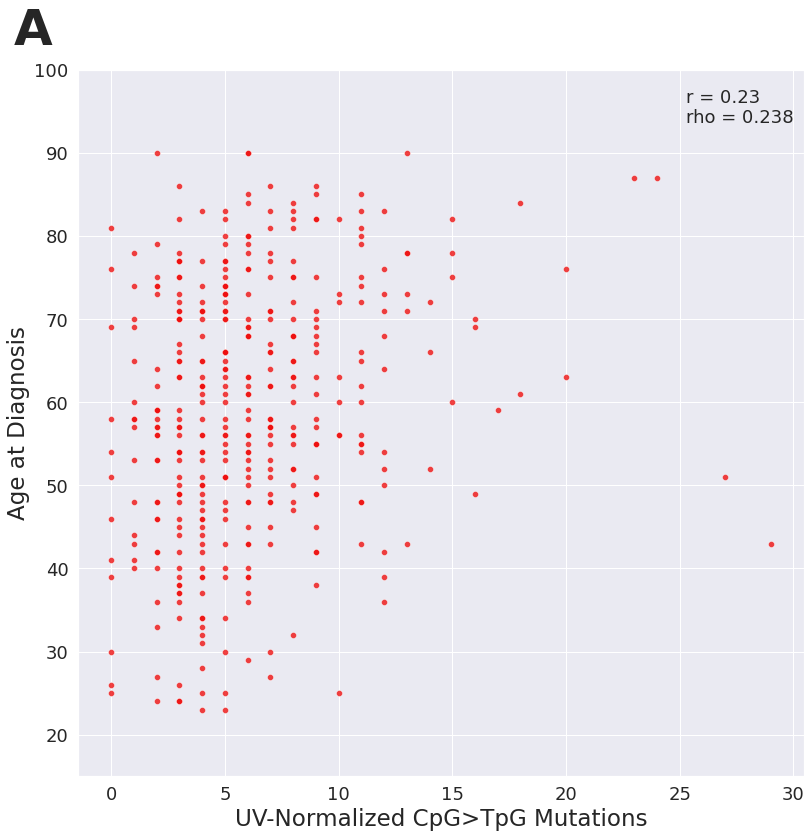

In [17]:
sns.set(font_scale = 1.1)
plt.figure(figsize = (13, 13))
plt.ylim(15, 100)
ax = sns.scatterplot(data = tcgaSummary, x = "CT_Mutation_Counts", y = "Age", color = "#EE0E0E", alpha = 0.79)
plt.text(25.3, 93.7, f"rho = {np.round(rhoSTenA, decimals = 3)}", fontsize = 18)
plt.text(25.3, 96, f"r = {np.round(rSTenA, decimals = 3)}", fontsize = 18)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("UV-Normalized CpG>TpG Mutations", fontsize = 23)
plt.ylabel("Age at Diagnosis", fontsize = 23)

ax.text(-4.3, 103, string.ascii_uppercase[0], size=50, weight='bold')

### Supplementary Figure 12C: UV-mutation spectrum corrected CpG>TpG mutation correlation with UV-associated mutational signature SBS7

Run correlation:

In [18]:
#Run both Pearson and Spearman r
rhoSTenB, pSpearmanSTenB = spearmanr(tcgaSummary.CT_Mutation_Counts, tcgaSummary.UV_Exposure)
rSTenB, pPearsonSTenB = pearsonr(tcgaSummary.CT_Mutation_Counts, tcgaSummary.UV_Exposure)

logging.info(f"CpG > TpG and SBS7 Correlation (Spearman): rho = {rhoSTenB}   p = {pSpearmanSTenB}")
logging.info(f"CpG > TpG and SBS7 Correlation (Pearson): r = {rSTenB}   p = {pPearsonSTenB}")

CpG > TpG and SBS7 Correlation (Spearman): rho = 0.35320186000330184   p = 4.158350319986617e-13
CpG > TpG and SBS7 Correlation (Pearson): r = 0.2842336761050939   p = 8.176202537310737e-09


Visualize results and generate figure panel:

Text(-5.6, 25200, 'C')

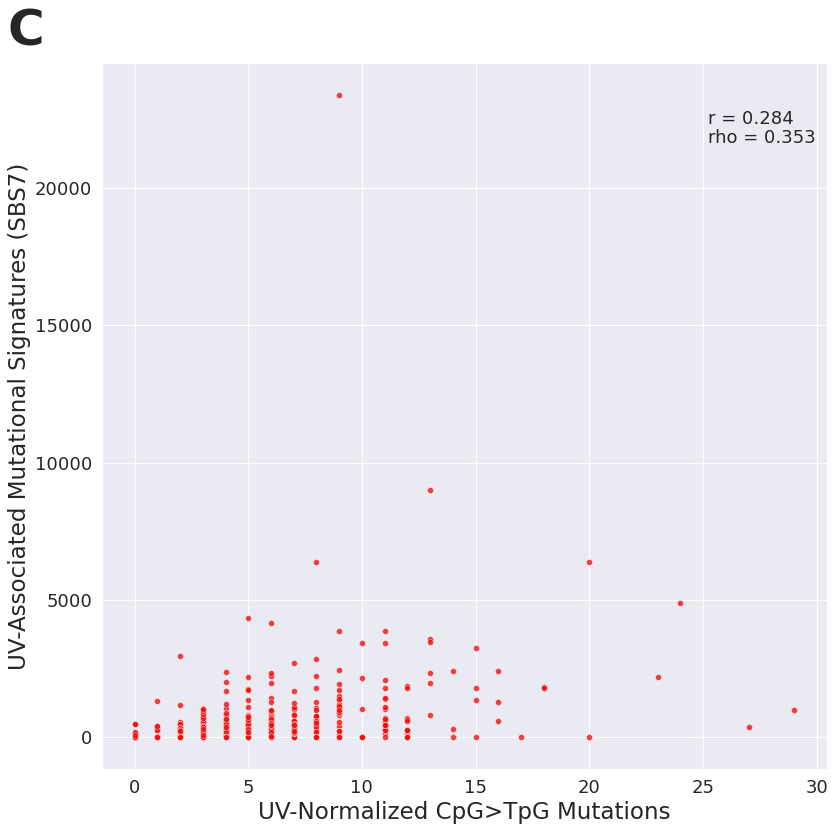

In [19]:
plt.figure(figsize = (13,13))
ax = sns.scatterplot(data = tcgaSummary, x = "CT_Mutation_Counts", y = "UV_Exposure", color = "#EE0E0E", alpha = 0.79)
plt.xlabel("UV-Normalized CpG>TpG Mutations", fontsize = 23)
plt.ylabel("UV-Associated Mutational Signatures (SBS7)", fontsize = 23)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.text(25.2, 22331, f"r = {np.round(rSTenB, decimals = 3)}", fontsize = 18)
plt.text(25.2, 21631, f"rho = {np.round(rhoSTenB, decimals = 3)}", fontsize = 18)

ax.text(-5.6, 25200, string.ascii_uppercase[2], size=50, weight='bold')

### Supplementary Figure 12B: SBS1 correlation with age of diagnosis

Run correlation:

In [20]:
rhoSBS1, pSBS1 = spearmanr(tcgaSummary.SBS1, tcgaSummary.Age)
rSBS1, pearsonPSBS1 = pearsonr(tcgaSummary.SBS1, tcgaSummary.Age)

logging.info(f"SBS1 and age of diagnosis (Spearman): rho = {rhoSBS1}   p = {pSBS1}")
logging.info(f"SBS1 and age of diagnosis (Pearson): r = {rSBS1}   p = {pearsonPSBS1}")

SBS1 and age of diagnosis (Spearman): rho = 0.210994154108081   p = 2.2493382277395787e-05
SBS1 and age of diagnosis (Pearson): r = 0.1116542653684446   p = 0.026105353641924355


Visualize results and generate figure panel:

Text(-65.3, 103, 'B')

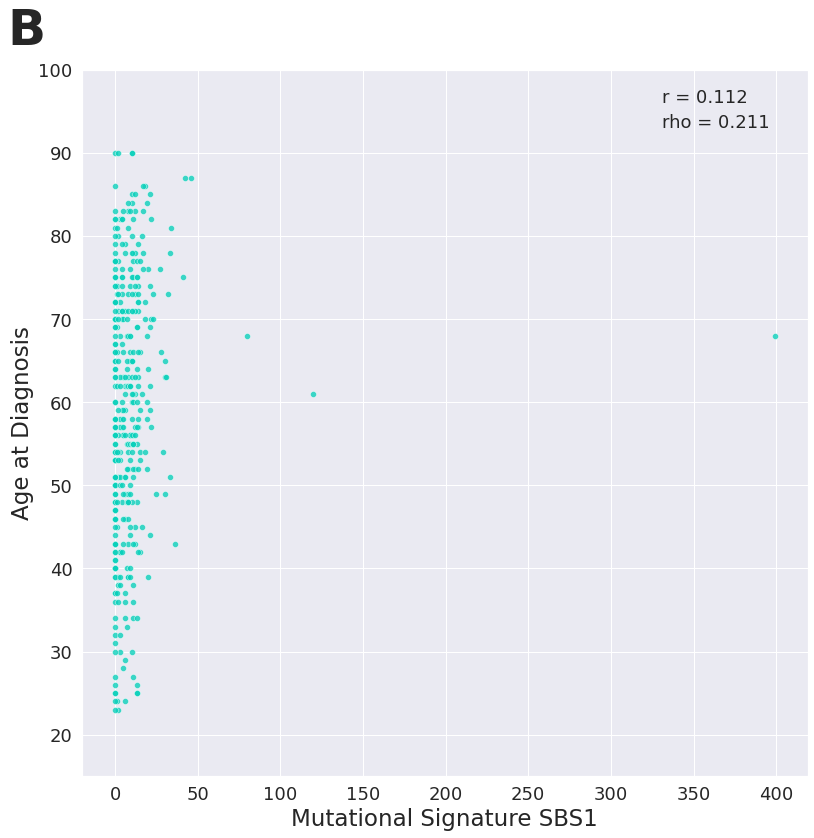

In [21]:
plt.figure(figsize = (13, 13))
plt.ylim(15, 100)
ax = sns.scatterplot(data = tcgaSummary, x = "SBS1", y = "Age", color = "#09D0BB", alpha = 0.79)

plt.text(331, 96, f"r = {np.round(rSBS1, decimals = 3)}", fontsize = 18)
plt.text(331, 93.1, f"rho = {np.round(rhoSBS1, decimals = 3)}", fontsize = 18)

plt.xlabel("Mutational Signature SBS1", fontsize = 23)
plt.ylabel("Age at Diagnosis", fontsize = 23)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

ax.text(-65.3, 103, string.ascii_uppercase[1], size=50, weight='bold')

### Supplementary Figure 12D: SBS1 with UV-associated mutational signature SBS7

Run correlation:

In [22]:
#Run both Pearson and Spearman r
rhoSTenD, pSpearmanSTenD = spearmanr(tcgaSummary.SBS1, tcgaSummary.UV_Exposure)
rSTenD, pPearsonSTenD = pearsonr(tcgaSummary.SBS1, tcgaSummary.UV_Exposure)

logging.info(f"SBS1 and SBS7 Correlation (Spearman): rho = {rhoSTenD}   p = {pSpearmanSTenD}")
logging.info(f"SBS1 and SBS7 Correlation (Pearson): r = {rSTenD}   p = {pPearsonSTenD}")

SBS1 and SBS7 Correlation (Spearman): rho = 0.434200757345676   p = 1.102476242931391e-19
SBS1 and SBS7 Correlation (Pearson): r = 0.8163861871720559   p = 3.2051574363566608e-96


Visualize results and generate figure panel:

Text(-85.3, 25200, 'D')

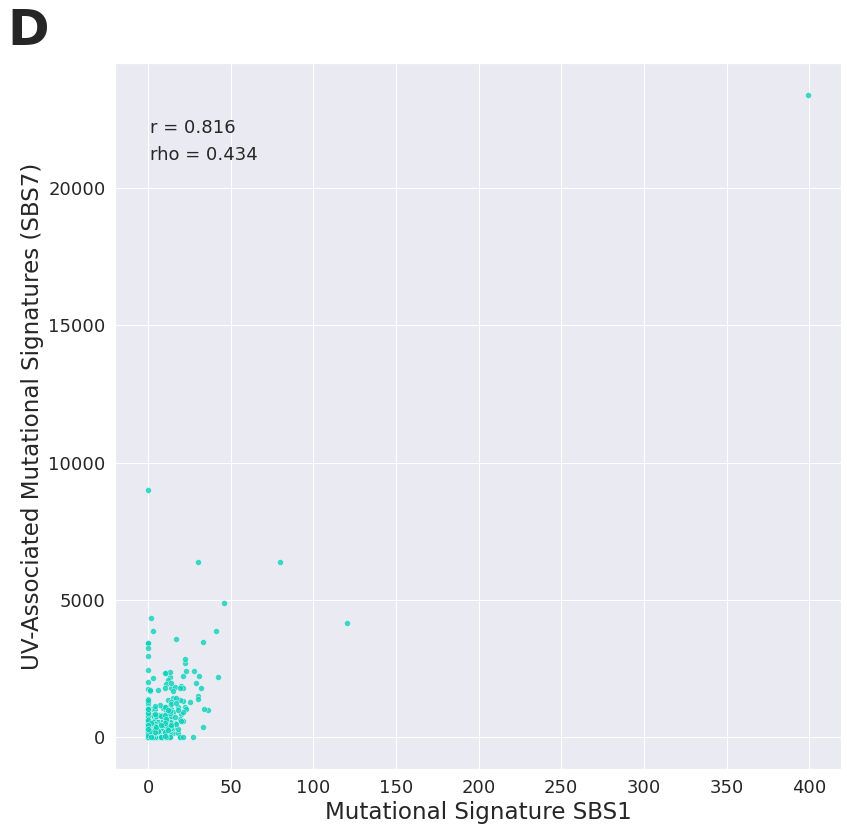

In [23]:
plt.figure(figsize = (13,13))
ax = sns.scatterplot(data = tcgaSummary, x = "SBS1", y = "UV_Exposure", color = "#09D0BB", alpha = 0.79)

plt.xlabel("Mutational Signature SBS1", fontsize = 23)
plt.ylabel("UV-Associated Mutational Signatures (SBS7)", fontsize = 23)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.text(1, 22006, f"r = {np.round(rSTenD, decimals = 3)}", fontsize = 18)
plt.text(1, 21006, f"rho = {np.round(rhoSTenD, decimals = 3)}", fontsize = 18)

ax.text(-85.3, 25200, string.ascii_uppercase[3], size=50, weight='bold')

**UV-mutation spectrum corrected CpG>TpG mutations correlate better with age of diagnosis and worse with SBS7 than SBS1. Given this use UV-mutation spectrum corrected CpG>TpG mutations as the clock-like signature for modeling. Model age of diagnosis as a f(x) of UV-mutation spectrum corrected CpG>TpG mutations to infer a per CpG>TpG mutation age contribution:**

In [24]:
#Run OLS model
ctModel = smf.ols(formula='Age ~ CT_Mutation_Counts', data = tcgaSummary).fit() #+ UV_Exposure
summary = ctModel.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,53.8241,1.347,39.944,0.000,51.175,56.473
CT_Mutation_Counts,0.8486,0.181,4.695,0.000,0.493,1.204


## 3. Utilizing UV-mutation spectrum corrected CpG>TpG mutations + Two-Stage Sex Specific Estimates to Personalize Sojourn Times

### Personalized Age of Onset Estimates: 

**Incorporating Sex Specific Differences and CpG > TpG mutations (minus CpCpG and TpCpG mutations)**

In [25]:
# Per C>T mutation age adjustment as estimated by OLS model
perMutationAdjustment = ctModel.params.CT_Mutation_Counts 

# Sex specific two-stage model estimates as reported in paper:
maleMeanTumorSojournTime = 8.35
femaleMeanTumorSojournTime = 9.64
sexAgeAdjustments = {"male": maleMeanTumorSojournTime , "female": femaleMeanTumorSojournTime}

#median C>T mutation - will be used to upscale/downscale sex specific tumor sojourn time by individual C>T mutations
medianMutationBurden = np.median(tcgaSummary.CT_Mutation_Counts)
logging.info(f"The median UV-normalized CpG > TpG mutation burden in SKCM TCGA individuals is {medianMutationBurden}")

The median UV-normalized CpG > TpG mutation burden in SKCM TCGA individuals is 5.0


Define a function to personalize age of onset as a f(x) of C>T mutation burden (if available) and sex.

In [26]:
'''
INPUT(s):
    1) inputDF: Pandas dataframe with sex specific information (Sex), age of diagnosis (Age), and CpG > TpG mutation burden (CT_Mutation_Counts)
    2) medianCT: Float corresponding to the relevant median mutation burden
    3) mutationAgeAdjustment: Float corresponding to unit age change per mutation relative to medianCT
    4) sexToAgeMapping: Dictionary mapping sex to tumor sojourn time

OUTPUT(s):
    1) screenedAgeDF: inputDF with an additional column (PersonalizedAgeOfOnset) of floats corresponding to personalized 
    age of onset/screening age for individuals 
    2) adjustmentBureau: dictionary mapping individuals/indices to their personalized age adjustment 
    (e.g., 5.9 years would equate to 5.9 years before age of diagnosis)
'''
def PersonalizeAgeOfOnset(inputDF, medianCT, mutationAgeAdjustment, sexToAgeMapping):
    assert pd.Series(["Age", "CT_Mutation_Counts", "Sex"]).isin(inputDF.columns).all()
    
    screenAges = list()
    adjustmentBureau = defaultdict(float)
    for i in inputDF.index:
        if np.isnan(inputDF.loc[i, "CT_Mutation_Counts"]): #individuals without C>T mutation information - set onset to sex specific offset:
            adjustmentBureau[i] = sexToAgeMapping[inputDF.loc[i, "Sex"]]
            screenAges.append(inputDF.loc[i, "Age"] - sexToAgeMapping[inputDF.loc[i, "Sex"]])
        
        else:
            #If have < median mutations -> shift age of onset up, if more move down
            screenAdjustment = sexToAgeMapping[inputDF.loc[i, "Sex"]] + ((inputDF.loc[i, "CT_Mutation_Counts"] - medianCT) * mutationAgeAdjustment) 
            
            assert screenAdjustment >= 0 #Can't have an age of onset after diagnosis - unless of course misdiagnosis, but assume all cases are properly diagnosed
            
            #Can potentially upper bound screen adjustment at 16 (upper range of timing of WGD - PCAWG paper)
            adjustmentBureau[i] = screenAdjustment
            screenAges.append(inputDF.loc[i, "Age"] - screenAdjustment)
            
    inputDF["PersonalizedAgeOfOnset"] = screenAges
    
    return inputDF, adjustmentBureau

Run for both those with and without PRS information:

In [27]:
tcgaSummaryPRSIndependent = tcgaSummaryAll.copy() #maintain a copy of the full dataset
tcgaSummaryAll = tcgaSummaryAll[~tcgaSummaryAll.PRS.isnull()] #those with PRS information
logging.info(f"Number of individuals with PRS: {tcgaSummaryAll.shape[0]}")

Number of individuals with PRS: 433


Partition into PRS quintiles:

In [28]:
tcgaSummaryAll["PRSQuintile"] = pd.qcut(tcgaSummaryAll["PRS"], q = 5, labels = False)
tcgaSummaryAll["PRSQuintile"] = tcgaSummaryAll["PRSQuintile"] + 1

Generate personalized individual tumor sojourn time and corresponding predicted age of onset for PRS subset of individuals: 

In [29]:
tcgaSummaryAll, iNowCommandYouToGoLeft = PersonalizeAgeOfOnset(inputDF = tcgaSummaryAll, medianCT = medianMutationBurden, mutationAgeAdjustment = perMutationAdjustment, sexToAgeMapping = sexAgeAdjustments)

In [30]:
byCorrection = sorted(iNowCommandYouToGoLeft.items(), key = lambda x: x[1], reverse = True)
logging.info("PERSONALIZED Age of Onset correction (for individuals with PRS : N = {}) ranges from {} to {} years prior to age of diagnosis.".format(len(iNowCommandYouToGoLeft), byCorrection[-1][1], byCorrection[0][1]))
del byCorrection

PERSONALIZED Age of Onset correction (for individuals with PRS : N = 433) ranges from 4.107055263442338 to 28.71613473547678 years prior to age of diagnosis.


Generate personalized individual tumor sojourn time and corresponding predicted age of onset for full dataset independent of whether individual has PRS or not:

In [31]:
tcgaSummaryPRSIndependent, prsIndependentShifts = PersonalizeAgeOfOnset(inputDF = tcgaSummaryPRSIndependent, medianCT = medianMutationBurden, mutationAgeAdjustment = perMutationAdjustment, sexToAgeMapping = sexAgeAdjustments)

In [32]:
byCorrection = sorted(prsIndependentShifts.items(), key = lambda x: x[1], reverse = True)
logging.info("PERSONALIZED Age of Onset correction FOR ALL N = {} ranges from {} to {} years prior to age of diagnosis.".format(len(prsIndependentShifts),byCorrection[-1][1], byCorrection[0][1]))
del byCorrection

PERSONALIZED Age of Onset correction FOR ALL N = 451 ranges from 4.107055263442338 to 28.71613473547678 years prior to age of diagnosis.


## 4) Investigating MHC-I AI Carriers Predicted Age of Onset across PRS Quintiles

Generate PRS Quintile Statistics:

In [33]:
quintileStats = defaultdict(lambda: defaultdict(float))

for i in range(1,6):
    stat,pRisk = mannwhitneyu(tcgaSummaryAll[(tcgaSummaryAll.PRSQuintile == i)&(tcgaSummaryAll.HasProtection)].PersonalizedAgeOfOnset, tcgaSummaryAll[(tcgaSummaryAll.PRSQuintile == i)&(~tcgaSummaryAll.HasProtection)].PersonalizedAgeOfOnset)
    noAiMedian =  np.median(tcgaSummaryAll[(tcgaSummaryAll.PRSQuintile == i)&(~tcgaSummaryAll.HasProtection)].PersonalizedAgeOfOnset)
    aiMedian = np.median(tcgaSummaryAll[(tcgaSummaryAll.PRSQuintile == i)&(tcgaSummaryAll.HasProtection)].PersonalizedAgeOfOnset) 
    quintileStats[i]["p"] = pRisk
    quintileStats[i]["AIMedianAge"] = aiMedian
    quintileStats[i]["NonAIMedianAge"] = noAiMedian

#Quintile results
quintileStats    

defaultdict(<function __main__.<lambda>()>,
            {1: defaultdict(float,
                         {'p': 0.01110552593332498,
                          'AIMedianAge': 55.8771165790327,
                          'NonAIMedianAge': 46.49858894731153}),
             2: defaultdict(float,
                         {'p': 0.14363416491594805,
                          'AIMedianAge': 51.347177894623066,
                          'NonAIMedianAge': 51.1957668419346}),
             3: defaultdict(float,
                         {'p': 0.17270812005225417,
                          'AIMedianAge': 50.65,
                          'NonAIMedianAge': 46.99858894731153}),
             4: defaultdict(float,
                         {'p': 0.01880759020449964,
                          'AIMedianAge': 53.20858894731153,
                          'NonAIMedianAge': 42.65}),
             5: defaultdict(float,
                         {'p': 0.48298035220515095,
                          'AIMedianAge': 45.65

### Supplementary Figure 12F: Personalized Predicted Age of Onset by MHC-AI Carrier Status across PRS Quintiles

Text(-1.034, 89, 'F')

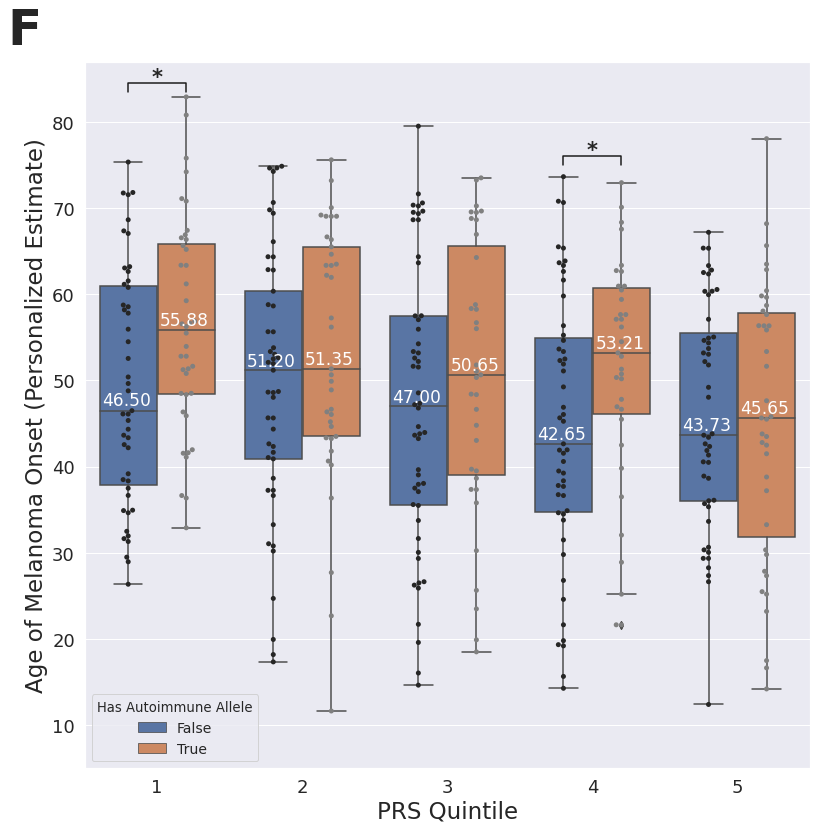

In [34]:
plt.figure(figsize=(13,13))
ax = sns.boxplot(x="PRSQuintile", y = "PersonalizedAgeOfOnset", hue = "HasProtection", data = tcgaSummaryAll)
sns.swarmplot(x="PRSQuintile", y = "PersonalizedAgeOfOnset", hue = "HasProtection", data = tcgaSummaryAll, dodge = True, color = "grey")
plt.xlabel("PRS Quintile", fontsize = 23)
plt.ylabel("Age of Melanoma Onset (Personalized Estimate)", fontsize = 23)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(5, 87)


handles, labels = ax.get_legend_handles_labels() #get rid of annoying double legend
ax.legend(handles[:2], labels[:2], title = "Has Autoimmune Allele", loc = 3, fontsize = 13, prop = {"size": 14})


#add significances:
plt.plot([-0.2,-0.2,0.2,0.2], [83.5, 84.5, 84.5, 83.5], lw = 1.5, c = 'k')
plt.text(-0.04, 84.5, "*", fontsize = 21, fontweight = "bold")
plt.plot([2.8,2.8,3.2,3.2], [75, 76, 76, 75], lw = 1.5, c = 'k')
plt.text(2.96, 76, "*", fontsize = 21, fontweight = "bold")

#add medians:
leftOffset = -0.03
plt.text(-0.35 + leftOffset, 47.1, "{0:.2f}".format(quintileStats[1]["NonAIMedianAge"]), color = "white", fontsize = 17)
plt.text(0.05 + leftOffset, 56.38, "{0:.2f}".format(quintileStats[1]["AIMedianAge"]), color = "white", fontsize = 17)

plt.text(0.65 + leftOffset, 51.7, "{0:.2f}".format(quintileStats[2]["NonAIMedianAge"]), color = "white", fontsize = 17)
plt.text(1.05 + leftOffset, 51.85, "{0:.2f}".format(quintileStats[2]["AIMedianAge"]), color = "white", fontsize = 17)

plt.text(1.65 + leftOffset, 47.5, "{0:.2f}".format(quintileStats[3]["NonAIMedianAge"]), color = "white", fontsize = 17)
plt.text(2.05 + leftOffset, 51.15, "{0:.2f}".format(quintileStats[3]["AIMedianAge"]), color = "white", fontsize = 17)

plt.text(2.65 + leftOffset, 43.15, "{0:.2f}".format(quintileStats[4]["NonAIMedianAge"]), color = "white", fontsize = 17)
plt.text(3.05 + leftOffset, 53.71, "{0:.2f}".format(quintileStats[4]["AIMedianAge"]), color = "white", fontsize = 17)

plt.text(3.65 + leftOffset, 44.23, "{0:.2f}".format(quintileStats[5]["NonAIMedianAge"]), color = "white", fontsize = 17)
plt.text(4.05 + leftOffset, 46.15, "{0:.2f}".format(quintileStats[5]["AIMedianAge"]), color = "white", fontsize = 17)

ax.text(-1.034, 89, string.ascii_uppercase[5], size=50, weight='bold')

## 5) Assessing Reasonability of Personalized Sojourn Time Estimates

#### Assessing Personalized Age Correction Estimates with Reported WGD Timing Estimates in Melanoma:

 - From [The evolutionary history of 2,568 cancers](https://www.nature.com/articles/s41586-019-1907-7) the estimated timing from whole genome duplication (WGD) to melanoma diagnosis is 5.7 years prior. Not unexpectedly, they report that the timing can be variable between WGD and diagnosis with WGD ranging between 3.2 and 16 years prior to diagnosis. Using WGD as a proxy for an event that occurs after onset, assess whether our predicted personalized estimates fall around the 5.7 year estimation, or on either end of the 3.2-16 year age range.

In [35]:
#Load in WGD information for the TCGA: 
wgd = pd.read_csv("../GenotypeData/TCGA_WGD_Scores.tsv", sep = "\t", index_col = 0)

WGD Scores are computed as $\text{WGD score} = \log_2(\text{ploidy} + \text{ploidy} \cdot \text{propLOH}) - 1$. Thus an individual without duplication should have a WGD score = 0. Here assign WGD status as those individuals with a WGD score >= 0.5.

In [36]:
wgdScoreThreshForDuplication = 0.5
tcgaSummaryAll["WGD_Score"] = [wgd.loc[i, "wgd"] if i in wgd.index else -1 for i in tcgaSummaryAll.index] #Note 27 individuals don't have WGD scores - assign them a score of -1 (which will equate to an assumption of no WGD)
tcgaSummaryAll["HasWGD"] = tcgaSummaryAll["WGD_Score"] >= wgdScoreThreshForDuplication

tcgaSummaryPRSIndependent["WGD_Score"] = [wgd.loc[i, "wgd"] if i in wgd.index else -1 for i in tcgaSummaryPRSIndependent.index]
tcgaSummaryPRSIndependent["HasWGD"] = tcgaSummaryPRSIndependent["WGD_Score"] >= wgdScoreThreshForDuplication

logging.info(f"There exist {sum(tcgaSummaryAll.HasWGD)} out of {tcgaSummaryAll.shape[0]} PRS individuals assigned WGD status at a WGD score of {wgdScoreThreshForDuplication} or greater.")
logging.info(f"There exist {sum(tcgaSummaryPRSIndependent.HasWGD)} out of {tcgaSummaryPRSIndependent.shape[0]} individuals assigned WGD status at a WGD score of {wgdScoreThreshForDuplication} or greater.")

There exist 213 out of 433 PRS individuals assigned WGD status at a WGD score of 0.5 or greater.
There exist 222 out of 451 individuals assigned WGD status at a WGD score of 0.5 or greater.


Assess the age correction for individuals with WGD across all discovery individuals (N = 451):

In [37]:
wgdMax = -1
wgdMin = np.inf

pcawgUpper = 16
pcawgLower = 3.2
numExceedUpperBound = 0
numExceedLowerBound = 0

for i in tcgaSummaryPRSIndependent[tcgaSummaryPRSIndependent.HasWGD].index:
    ageCorrection = prsIndependentShifts[i]
    
    if ageCorrection < wgdMin:
        wgdMin = ageCorrection
        
    if ageCorrection > wgdMax:
        wgdMax = ageCorrection
        
    if ageCorrection < pcawgLower: #lower bound of WGD range
        numExceedLowerBound +=1
        
    if ageCorrection > pcawgUpper: #upper bound of WGD range
        numExceedUpperBound += 1

logging.info(f"In individuals with WGD the largest personalized adjustment was {wgdMax} years prior to diagnosis")
logging.info(f"There are {numExceedUpperBound} individuals with personalized estimates above the PCAWG WGD to diagnosis upper range of {pcawgUpper}")
logging.info(f"In individuals with WGD the smallest personalized adjustment was {wgdMin} years prior to diagnosis")
logging.info(f"There are {numExceedLowerBound} individuals with personalized estimates below the PCAWG WGD to diagnosis lower range of {pcawgLower}")

tcgaSummaryPRSIndependent["PersonalizedAgeCorrection"] = [prsIndependentShifts[i] for i in tcgaSummaryPRSIndependent.index] #Map to dataframe for visualization

In individuals with WGD the largest personalized adjustment was 28.71613473547678 years prior to diagnosis
There are 13 individuals with personalized estimates above the PCAWG WGD to diagnosis upper range of 16
In individuals with WGD the smallest personalized adjustment was 4.955644210753871 years prior to diagnosis
There are 0 individuals with personalized estimates below the PCAWG WGD to diagnosis lower range of 3.2


### Supplementary Figure 12E: Tumor Dwell Times in WGD and non-WGD Melanomas

Statistical Test: MWU test for predicted sojourn/tumor dwell times by tumor WGD status

In [38]:
_, wgdStatusAgeEstimatePvalAll = mannwhitneyu(tcgaSummaryPRSIndependent[tcgaSummaryPRSIndependent.HasWGD].PersonalizedAgeCorrection, tcgaSummaryPRSIndependent[~tcgaSummaryPRSIndependent.HasWGD].PersonalizedAgeCorrection)
logging.info(f"MWU Test p-value: {wgdStatusAgeEstimatePvalAll}")

MWU Test p-value: 3.0463780803820443e-06


Generate Figure:

Text(-0.71, 30.5, 'E')

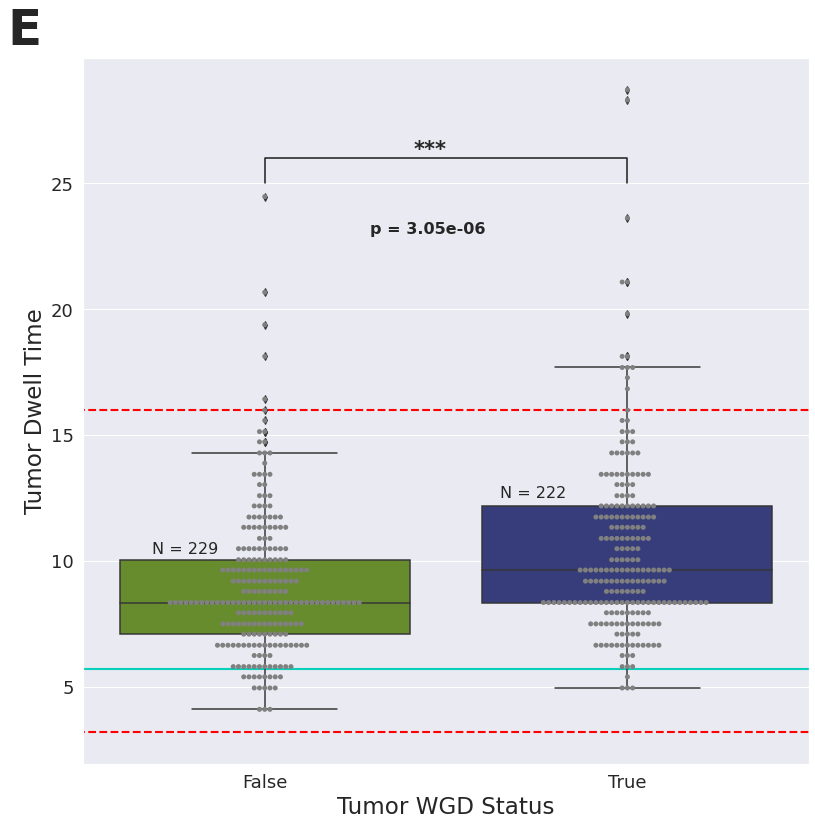

In [39]:
wgdColorPalette = {False: "#6A9C1E", True:"#2B3485"}

plt.figure(figsize = (13, 13))
ax = sns.boxplot(data = tcgaSummaryPRSIndependent, y = "PersonalizedAgeCorrection", x = "HasWGD", palette = wgdColorPalette)
sns.swarmplot(data = tcgaSummaryPRSIndependent, y = "PersonalizedAgeCorrection", x = "HasWGD", color = "grey", dodge = True)

plt.hlines(pcawgUpper, -1.5, 1.5, color = "red", lw = 2.1, linestyle = "--")
plt.hlines(pcawgLower, -1.5, 1.5, color = "red", lw = 2.1, linestyle = "--")
plt.hlines(5.7, -1.5, 1.5, color = "#09D0BB", lw = 2.1, linestyle = "-") 
plt.plot([0,0,1,1], [25, 26, 26, 25], lw = 1.5, c = 'k')
plt.text(0.41, 26.1, "***", fontsize = 21, fontweight = "bold")

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Tumor Dwell Time", fontsize = 23) #Personalized Age of Onset Correction from Diagnosis
plt.xlabel("Tumor WGD Status", fontsize = 23)

plt.text(0.29, 23, "p = {0:0.3g}".format(wgdStatusAgeEstimatePvalAll), fontsize = 16, fontweight = "bold")
plt.text(0.65, 12.51, "N = {}".format(tcgaSummaryPRSIndependent[tcgaSummaryPRSIndependent.HasWGD].shape[0]), fontsize = 16)
plt.text(-0.31, 10.3, "N = {}".format(tcgaSummaryPRSIndependent[~tcgaSummaryPRSIndependent.HasWGD].shape[0]), fontsize = 16)

ax.text(-0.71, 30.5, string.ascii_uppercase[4], size=50, weight='bold')

## 6) Investigating MHC-I AI Carriers and Personalized Estimated Sojourn Times

Statistical Test: MWU test for predicted sojourn/tumor dwell times by AI carrier status

In [40]:
_, dAIAnotherDayp = mannwhitneyu(tcgaSummaryPRSIndependent[tcgaSummaryPRSIndependent.HasProtection].PersonalizedAgeCorrection, tcgaSummaryPRSIndependent[~tcgaSummaryPRSIndependent.HasProtection].PersonalizedAgeCorrection)
logging.info(f"MWU Test p-value: {dAIAnotherDayp}")

MWU Test p-value: 0.290438768419804


Visualize Differences:

Text(-0.31, 11.51, 'N = 261')

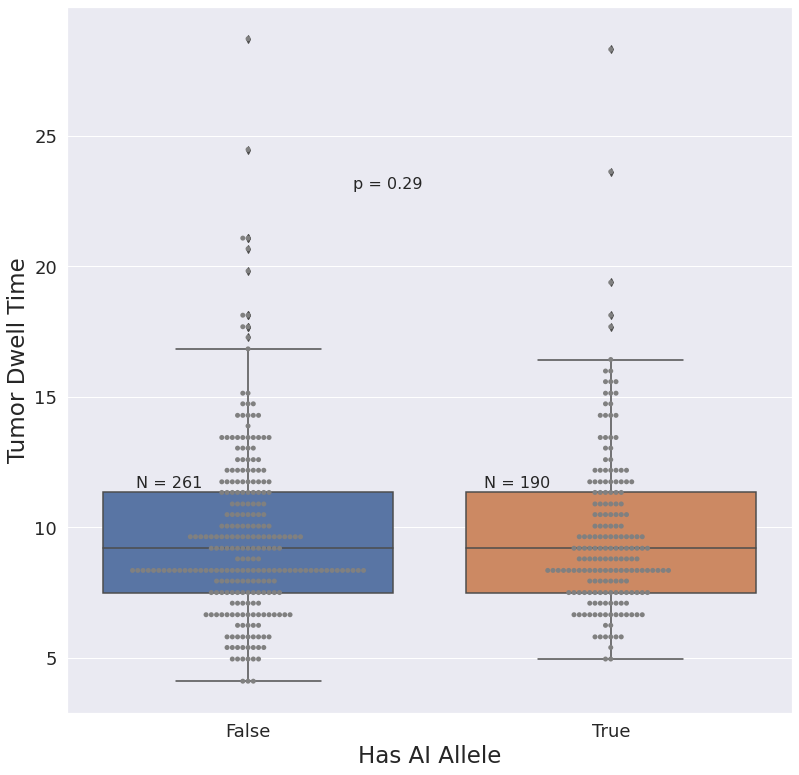

In [41]:
plt.figure(figsize = (13, 13))
ax = sns.boxplot(data = tcgaSummaryPRSIndependent, y = "PersonalizedAgeCorrection", x = "HasProtection")
sns.swarmplot(data = tcgaSummaryPRSIndependent, y = "PersonalizedAgeCorrection", x = "HasProtection", color = "grey", dodge = True)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Tumor Dwell Time", fontsize = 23) #Personalized Age of Onset Correction from Diagnosis
plt.xlabel("Has AI Allele", fontsize = 23)

plt.text(0.29, 23, "p = {0:0.3g}".format(dAIAnotherDayp), fontsize = 16)
plt.text(0.65, 11.51, "N = {}".format(tcgaSummaryPRSIndependent[tcgaSummaryPRSIndependent.HasProtection].shape[0]), fontsize = 16)
plt.text(-0.31, 11.51, "N = {}".format(tcgaSummaryPRSIndependent[~tcgaSummaryPRSIndependent.HasProtection].shape[0]), fontsize = 16)

**Assess whether any significant differences occur when also stratifying by WGD status:**
    
Statistical Tests: MWU test for predicted sojourn/tumor dwell times by AI carrier status in both WGD and non-WGD tumors

In [42]:
_, pWGD = mannwhitneyu(tcgaSummaryPRSIndependent[(tcgaSummaryPRSIndependent.HasProtection)&(tcgaSummaryPRSIndependent.HasWGD)].PersonalizedAgeCorrection, tcgaSummaryPRSIndependent[(~tcgaSummaryPRSIndependent.HasProtection)&(tcgaSummaryPRSIndependent.HasWGD)].PersonalizedAgeCorrection)
_, pNoWGD = mannwhitneyu(tcgaSummaryPRSIndependent[(tcgaSummaryPRSIndependent.HasProtection)&(~tcgaSummaryPRSIndependent.HasWGD)].PersonalizedAgeCorrection, tcgaSummaryPRSIndependent[(~tcgaSummaryPRSIndependent.HasProtection)&(~tcgaSummaryPRSIndependent.HasWGD)].PersonalizedAgeCorrection)

logging.info(f"MWU Test p-value for AI status in WGD tumors: {pWGD}")
logging.info(f"MWU Test p-value for AI status in non-WGD tumors: {pNoWGD}")

MWU Test p-value for AI status in WGD tumors: 0.49321347732020426
MWU Test p-value for AI status in non-WGD tumors: 0.1660934446710297


### Supplementary Figure 12G: Estimated Tumor Dwell Time Differences in MHC-I AI Carriers in both WGD and non-WGD Tumors

Text(-0.71, 30.5, 'G')

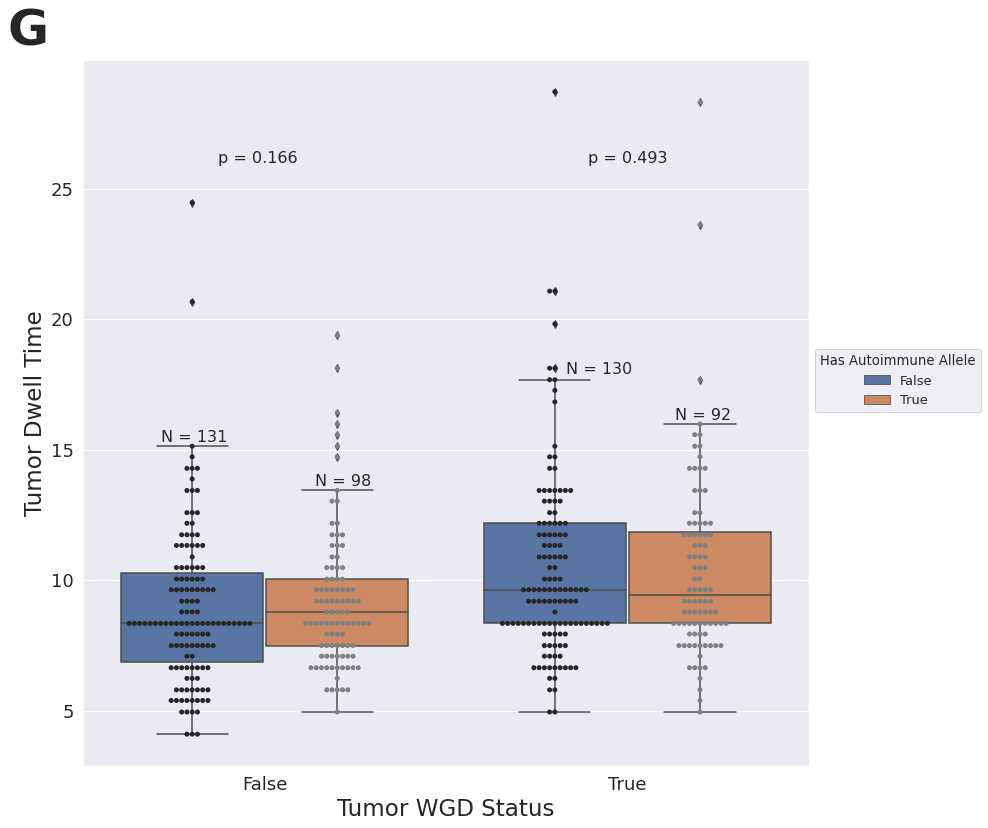

In [43]:
plt.figure(figsize = (13, 13))
ax = sns.boxplot(data = tcgaSummaryPRSIndependent, y = "PersonalizedAgeCorrection", hue = "HasProtection", x = "HasWGD")
sns.swarmplot(data = tcgaSummaryPRSIndependent, y = "PersonalizedAgeCorrection", hue = "HasProtection", x = "HasWGD", color = "grey", dodge = True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title = "Has Autoimmune Allele", fontsize = 12, prop = {"size": 13}, bbox_to_anchor=(1, 0.6))

plt.text(-0.13, 26, "p = {0:0.3g}".format(pNoWGD), fontsize = 16)
plt.text(0.89, 26, "p = {0:0.3g}".format(pWGD), fontsize = 16)

plt.text(-0.285, 15.31, f"N = {tcgaSummaryPRSIndependent[(~tcgaSummaryPRSIndependent.HasProtection)&(~tcgaSummaryPRSIndependent.HasWGD)].shape[0]}", fontsize = 16)
plt.text(0.139, 13.61, f"N = {tcgaSummaryPRSIndependent[(tcgaSummaryPRSIndependent.HasProtection)&(~tcgaSummaryPRSIndependent.HasWGD)].shape[0]}", fontsize = 16)
plt.text(0.83, 17.9, f"N = {tcgaSummaryPRSIndependent[(~tcgaSummaryPRSIndependent.HasProtection)&(tcgaSummaryPRSIndependent.HasWGD)].shape[0]}", fontsize = 16)
plt.text(1.13, 16.15, f"N = {tcgaSummaryPRSIndependent[(tcgaSummaryPRSIndependent.HasProtection)&(tcgaSummaryPRSIndependent.HasWGD)].shape[0]}", fontsize = 16)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.ylabel("Tumor Dwell Time", fontsize = 23) #Personalized Age of Onset Correction from Diagnosis
plt.xlabel("Tumor WGD Status", fontsize = 23)

ax.text(-0.71, 30.5, string.ascii_uppercase[6], size=50, weight='bold')